A)Split the data set into a training set and a test set.

In [ ]:
!pip install ISLP scikit-learn

In [ ]:
!pip install numpy==1.24.4 --force-reinstall

In [1]:
from ISLP import load_data
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [3]:
carseats = load_data('Carseats')
carseats.head()
X = carseats.drop('Sales', axis=1)
y = carseats['Sales']
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1515)


b)Fit a regression tree to the training set.

In [4]:
regression_tree = DecisionTreeRegressor(random_state=1515)
regression_tree.fit(X_train, y_train)



DecisionTreeRegressor(random_state=1515)

b) Plot the tree and interpret results

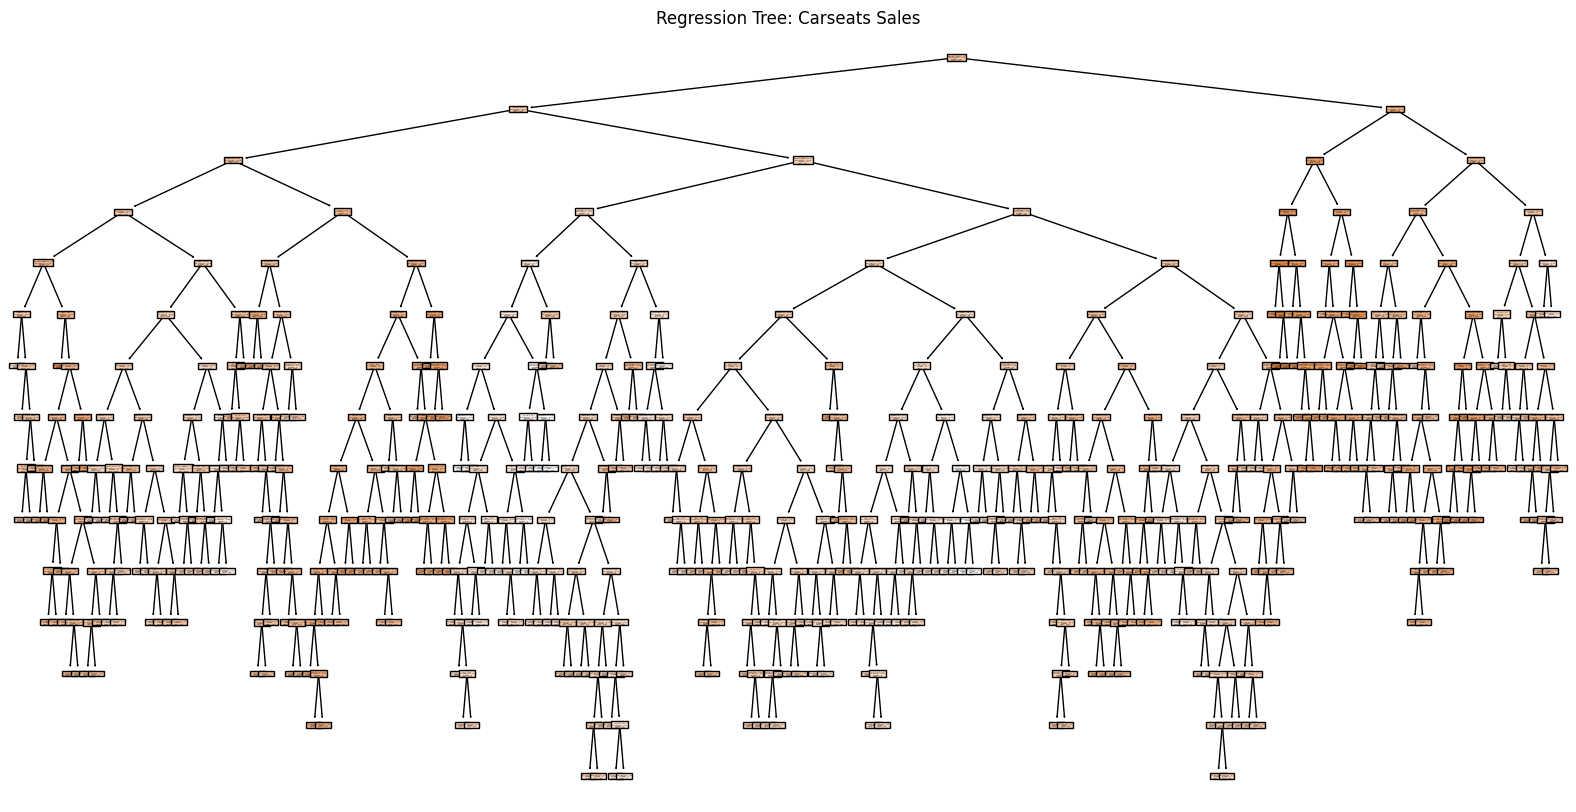

In [5]:
plt.figure(figsize=(20, 10))
plot_tree(regression_tree, feature_names=X.columns, filled=True)
plt.title("Regression Tree: Carseats Sales")
plt.show()

b)Interpretation:

Our initial tree is extremely deep with many nodes, suggesting overfitting. This model will likely have a low training error, but a high test error. When a model is overfit like this, it has memorized noise in the training data. The first split is indicative of the most important predictor in the model, which in this case is price.

b) Mean Squared Error

In [6]:
import numpy as np
y_pred = regression_tree.predict(X_test)
mean_squared_error(y_test, y_pred)


5.0579725

c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [7]:
path = DecisionTreeRegressor(random_state=1515).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas #Gives complexity paramters

In [8]:
cv_scores = []
for alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=1515, ccp_alpha=alpha)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    cv_scores.append(np.mean(scores))


ccp_alphas[np.argmax(cv_scores)]

0.07461464903846157

In [9]:
best_tree = DecisionTreeRegressor(random_state=1515, ccp_alpha=0.040070130085079814)
best_tree.fit(X_train, y_train)

best_y_pred = best_tree.predict(X_test)
mean_squared_error(y_test, best_y_pred)

5.218094841523483

Using cross validation to determine the optimal level of tree complexity, we get a new MSE of 5.218, slightly lower than our original.

d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important.

In [11]:
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=500,
    random_state=1515,
    oob_score=True,
    n_jobs=-1
)

bagging_model.fit(X_train, y_train)

bag_y_pred = bagging_model.predict(X_test)

mean_squared_error(y_test, bag_y_pred)

2.6521683205550057

Our MSE after using the bagging approach is 2.652, significantly less than our CV and initial MSE's. Bagging was able to bring the overall variance down by aggregating across trees.

According to the feature importance values, price is the most influential predictor of carseat sales. Followed by price is shelf location being good, comp price, and advertising. Urban/non urban has the least weight in determining sales. The best predictors were determined based on which splits reduced the gini index/variance the most.

In [18]:


importances = np.array([tree.feature_importances_ for tree in bagging_model.estimators_])
avg_importances = np.mean(importances, axis=0)
feature_names = X_train.columns
importance_dict = dict(zip(feature_names, avg_importances))


importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': avg_importances
})

print(importance_df.sort_values(by='Importance', ascending=False))

             Feature  Importance
4              Price    0.313161
7     ShelveLoc_Good    0.198119
0          CompPrice    0.126295
2        Advertising    0.107428
5                Age    0.078281
1             Income    0.048920
8   ShelveLoc_Medium    0.042347
3         Population    0.040774
6          Education    0.031504
10            US_Yes    0.008028
9          Urban_Yes    0.005143


e) Random Forest

In [20]:
rand_forest = RandomForestRegressor(n_estimators=500, random_state=1515, n_jobs=-1)
rand_forest.fit(X_train, y_train)

rf_preds = rand_forest.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_mse

2.6370638978100054

In [21]:
rf_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rand_forest.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(rf_importances)

             Feature  Importance
4              Price    0.313393
7     ShelveLoc_Good    0.198184
0          CompPrice    0.126090
2        Advertising    0.107606
5                Age    0.078284
1             Income    0.049301
8   ShelveLoc_Medium    0.042371
3         Population    0.040367
6          Education    0.031114
10            US_Yes    0.007935
9          Urban_Yes    0.005353


Using a random forest model with 500 trees, we get a test MSE of 2.638, which is barely little lower than the bagging model. By performing feature selection across predictors, the random forest was able to reduce the residuals. The feature importance output looks almost identical to the bagging model. The order of the features remained the same, while the importance output varied slightly. The best predictors were determined based on which splits reduced the gini index/variance the most. Overall in both models, it appears that price is the most significant predictor in determining car seat sales (thousands of $)

Describe the effect of m, the number of variables considered at each split, on the error rate obtained.


To do this, I took the same code as above and played around with the max_features variable. M represents the number of features considered randomly at each potential split. The default above was m = sqrt(p), which resulted in a MSE of 2.6370. I began by reducing m to 2 to play around and see what happens, and the MSE shot up to 3.67. When I add one more predictor in at a time, (keeping in mind theres only 11? variables in the data), the MSE gets smaller and smaller consecutively. An m=1 model gave the worst MSE in the random forest, as it was trying to predict based off of one random feature.

One thing to note is that the worst performing random forest model still performed better than some of our initial models, even when trying to predict based off one one random predictor! I thought maybe I messed something up but when I looked it up, I realized this was just demonstrating how good random forests are at reducing variance. By aggregating so many predictions, the overall MSE was reduced.



In [31]:
rf_testing = RandomForestRegressor(n_estimators=500, max_features=1, random_state=1515, n_jobs=-1)
rf_testing.fit(X_train, y_train)
testing_pred = rf_testing.predict(X_test)
test_mse = mean_squared_error(y_test, testing_pred)
print(test_mse)

4.881105191970007


In [32]:
rf_testing = RandomForestRegressor(n_estimators=500, max_features=2, random_state=1515, n_jobs=-1)
rf_testing.fit(X_train, y_train)
testing_pred = rf_testing.predict(X_test)
test_mse = mean_squared_error(y_test, testing_pred)
print(test_mse)

3.6710639400950056


In [33]:
rf_testing = RandomForestRegressor(n_estimators=500, max_features=3, random_state=1515, n_jobs=-1)
rf_testing.fit(X_train, y_train)
testing_pred = rf_testing.predict(X_test)
test_mse = mean_squared_error(y_test, testing_pred)
print(test_mse)

3.2156798210650033
